In [1]:
# Enable Float64 for more stable matrix inversions.
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit
import optax as ox

import gpjax as gpx
from gpjax.typing import (Array, Float)
from gpjax.decision_making.decision_maker import UtilityDrivenDecisionMaker
from gpjax.decision_making.posterior_handler import PosteriorHandler
from gpjax.decision_making.search_space import ContinuousSearchSpace
from gpjax.decision_making.utils import ( OBJECTIVE, build_function_evaluator)
from gpjax.decision_making.utility_functions import ThompsonSampling
from gpjax.decision_making.utility_maximizer import ContinuousSinglePointUtilityMaximizer

import matplotlib as mpl
import matplotlib.pyplot as plt

from RCF_JAX import RCF

key  = jax.random.PRNGKey(1846)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

/Users/jcandane/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jcandane/miniconda3/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


# initial data collection

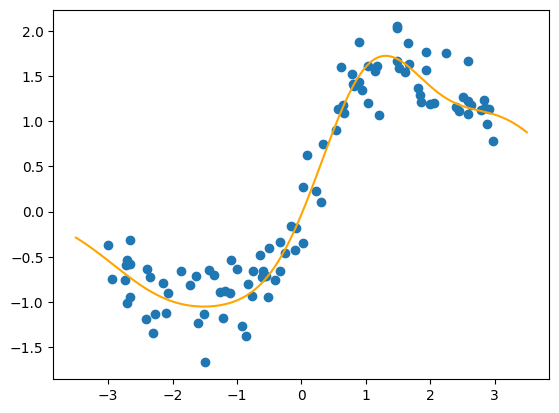

In [2]:
f = RCF(jax.numpy.array([[-3.,3.]]), 6, MO=1, seed=7655)
n = 100
noise = 0.25

### DATASET
IN_ix  = jax.random.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
OUT_iX = f.evalulate( IN_ix ) + noise * jax.random.normal(jax.random.PRNGKey(1234), shape=(IN_ix.shape[0],))[:,None]
D      = gpx.Dataset(X=IN_ix, y=OUT_iX)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f.evalulate(xtest)


plt.scatter( IN_ix.flatten(), OUT_iX.flatten() )
plt.plot( xtest.flatten(), ytest.flatten() , color="orange")
plt.show()

# gp START

/Users/jcandane/miniconda3/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Array([[-0.69004069, -0.70695658, -0.72555504, ..., -0.21957266,
        -0.22142794, -0.22093046],
       [-0.72533916, -0.71948142, -0.71670094, ..., -0.54612619,
        -0.54147235, -0.53543469],
       [ 0.59551805,  0.63034285,  0.66403761, ..., -0.70101367,
        -0.7114403 , -0.72338487]], dtype=float64)

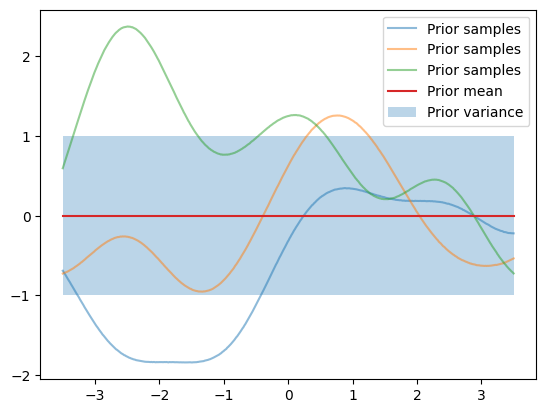

In [3]:
kernel = gpx.kernels.RBF()
meanf  = gpx.mean_functions.Zero()

prior      = gpx.gps.Prior(mean_function=meanf, kernel=kernel)  ## {μ, K}

key = jax.random.PRNGKey(123)
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std  = prior_dist.variance()
samples    = prior_dist.sample(seed=key, sample_shape=(3,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, label="Prior samples")
ax.plot(xtest, prior_mean, label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    label="Prior variance",
)
ax.legend(loc="best")

samples

In [4]:
#kernel = gpx.kernels.RBF()
#meanf  = gpx.mean_functions.Zero()

#prior      = gpx.gps.Prior(mean_function=meanf, kernel=kernel)  ## {μ, K}
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior  = prior * likelihood

#### 
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

### like gpCAM's .train()
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D
)


Initial loss is 105.00020574055551
Optimization was successful
Final loss is 20.534940439568114 after 17 iterations


In [5]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

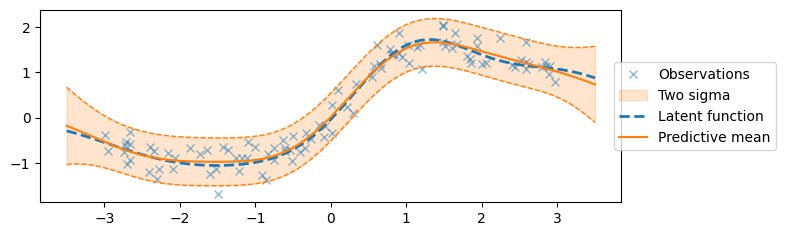

In [6]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(IN_ix.flatten(), OUT_iX.flatten(), "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
) ### bottom 
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
) ## top
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
) ##truth
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1]) ## result mean
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

# !! how to next sample IN, to reduce uncertainty the most

https://docs.jaxgaussianprocesses.com/examples/decision_making/#the-utility-function

In [7]:
likelihood_builder = lambda n: gpx.likelihoods.Gaussian( num_datapoints=n, obs_stddev=jnp.array(1e-3) )

posterior_handler = PosteriorHandler(
    prior,
    likelihood_builder=likelihood_builder,
    optimization_objective=gpx.objectives.ConjugateMLL(negative=True),
    optimizer=ox.adam(learning_rate=0.01),
    num_optimization_iters=1000,
)
posterior_handlers = {OBJECTIVE: posterior_handler}

utility_function_builder = ThompsonSampling(num_features=500)



In [8]:
def forrester(x: Float[Array, "N 1"]) -> Float[Array, "N 1"]:
    return (6 * x - 2) ** 2 * jnp.sin(12 * x - 4)

def plot_bo_iteration(
    dm: UtilityDrivenDecisionMaker, last_queried_points: Float[Array, "B D"]
):
    posterior = dm.posteriors[OBJECTIVE]
    dataset = dm.datasets[OBJECTIVE]
    plt_x = jnp.linspace(0, 1, 1000).reshape(-1, 1)
    forrester_y = forrester(plt_x.squeeze(axis=-1))
    utility_fn = dm.current_utility_functions[0]
    sample_y = -utility_fn(plt_x)

    latent_dist = posterior.predict(plt_x, train_data=dataset)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    fig, ax = plt.subplots()
    ax.plot(plt_x.squeeze(), predictive_mean, label="Predictive Mean", color=cols[1])
    ax.fill_between(
        plt_x.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        plt_x.squeeze(),
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        plt_x.squeeze(),
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(plt_x.squeeze(), sample_y, label="Posterior Sample")
    ax.plot(
        plt_x.squeeze(),
        forrester_y,
        label="Forrester Function",
        color=cols[0],
        linestyle="--",
        linewidth=2,
    )
    ax.axvline(x=0.757, linestyle=":", color=cols[3], label="True Optimum")
    ax.scatter(dataset.X, dataset.y, label="Observations", color=cols[2], zorder=2)
    ax.scatter(
        last_queried_points[0],
        -utility_fn(last_queried_points[0][None, ...]),
        label="Posterior Sample Optimum",
        marker="*",
        color=cols[3],
        zorder=3,
    )
    ax.legend(loc="center left", bbox_to_anchor=(0.950, 0.5))
    plt.show()

In [11]:
lower_bounds = f.domain.T[0]
upper_bounds = f.domain.T[1]
search_space = ContinuousSearchSpace( lower_bounds=lower_bounds, upper_bounds=upper_bounds )

initial_x = search_space.sample(5, key)
initial_datasets = f.evalulate(initial_x) #function_evaluator(initial_x) ## f.evaluate

acquisition_maximizer = ContinuousSinglePointUtilityMaximizer( num_initial_samples=100, num_restarts=1 )

dm = UtilityDrivenDecisionMaker(
    search_space=search_space,
    posterior_handlers=posterior_handlers,
    datasets=initial_datasets,
    utility_function_builder=utility_function_builder,
    utility_maximizer=acquisition_maximizer,
    batch_size=1,
    key=key,
    post_ask=[plot_bo_iteration],
    post_tell=[],
)

results = dm.run(
    6,
    black_box_function_evaluator=f.evalulate,
)

AttributeError: 'ArrayImpl' object has no attribute 'keys'

In [10]:
initial_datasets

Array([[-1.0466794 ],
       [ 1.10570516],
       [-0.30257691],
       [ 1.0462983 ],
       [-0.85038193]], dtype=float64)

Array([-3.], dtype=float64)